In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [6]:
# Load data
YOUTH_DATA_REGRESSION_ = pd.read_csv("/Users/venkat/Downloads/youth_data.csv")

# Replace special codes with NaN
special_codes = [91, 93, 94, 97, 98, 991, 993, 994, 997, 998, 999, 9997, 9998]
YOUTH_DATA_REGRESSION_.replace(special_codes, np.nan, inplace=True)



In [33]:

YOUTH_DATA_REGRESSION_["BEHAVIOR_RISK_INDEX"] = (
    2 * YOUTH_DATA_REGRESSION_["YOSELL2"].fillna(0) +
    1.5 * YOUTH_DATA_REGRESSION_["YOATTAK2"].fillna(0) +
    1.5 * YOUTH_DATA_REGRESSION_["YOSTOLE2"].fillna(0) +
    1.2 * YOUTH_DATA_REGRESSION_["YOFIGHT2"].fillna(0) +
    3 * YOUTH_DATA_REGRESSION_["YOHGUN2"].fillna(0)
)


Creating a target variable  BEHAVIOR_RISK_INDEX using YOSELL2(selling Drugs) ,YOATTAK2(attacking nature),YOSTOLE2,YOFIGHT2,YOHGUN2

In [36]:
numeric_data = YOUTH_DATA_REGRESSION_.select_dtypes(include=["number"]).drop(columns=["BEHAVIOR_RISK_INDEX"])
vt = VarianceThreshold(threshold=0.01)
X_filtered = vt.fit_transform(numeric_data)
predictor_cols = numeric_data.columns[vt.get_support()]
YOUTH_DATA_Model = YOUTH_DATA_REGRESSION_[predictor_cols.tolist() + ["BEHAVIOR_RISK_INDEX"]].copy()
YOUTH_DATA_Model = YOUTH_DATA_Model[YOUTH_DATA_Model["BEHAVIOR_RISK_INDEX"].notna()]  # Keep rows with target
target = "BEHAVIOR_RISK_INDEX"

In [40]:
train_set = YOUTH_DATA_REGRESSION_[3000:]
test_set = YOUTH_DATA_REGRESSION_[:3000]

X_train = train_set[predictor_cols]
y_train = train_set[target]
X_test = test_set[predictor_cols]
y_test = test_set[target]

imputer = SimpleImputer(strategy="median")
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

print("Train set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Train set shape: (7561, 79)
Test set shape: (3000, 79)


In [46]:
models = {
    "Decision Tree": DecisionTreeRegressor(max_depth=5, random_state=42),
    "Bagging": BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=5), n_estimators=100, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=6, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
}


Trained Models

In [50]:
results = {}
for name, model in models.items():
    model.fit(X_train_imputed, y_train)
    y_pred = model.predict(X_test_imputed)
    results[name] = {
        "MSE": mean_squared_error(y_test, y_pred),
        "MAE": mean_absolute_error(y_test, y_pred),
        "R2": r2_score(y_test, y_pred),
        "y_pred": y_pred
    }


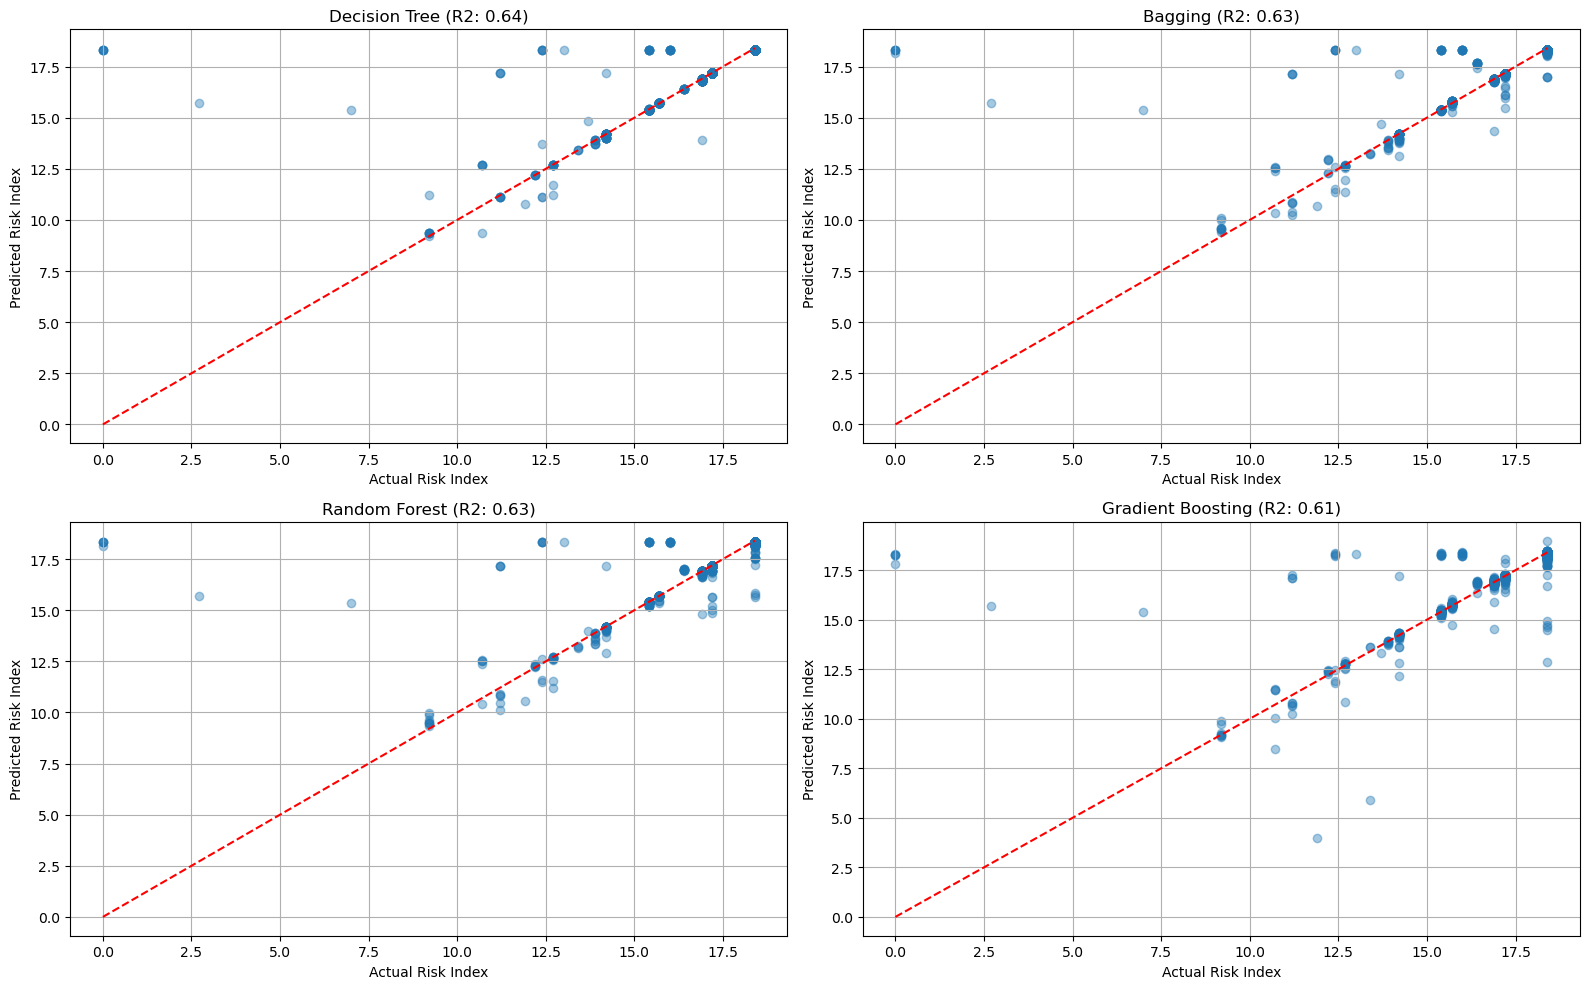

In [51]:
plt.figure(figsize=(16, 10))
for i, (name, res) in enumerate(results.items(), 1):
    plt.subplot(2, 2, i)
    plt.scatter(y_test, res["y_pred"], alpha=0.4)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual Risk Index")
    plt.ylabel("Predicted Risk Index")
    plt.title(f"{name} (R2: {res['R2']:.2f})")
    plt.grid(True)
plt.tight_layout()
plt.show()

In [54]:
summary = pd.DataFrame({
    model: {
        "MSE": f"{res['MSE']:.3f}",
        "MAE": f"{res['MAE']:.3f}",
        "R2": f"{res['R2']:.3f}"
    } for model, res in results.items()
}).T

print("Final Model Evaluation Summary:")
print(summary)

Final Model Evaluation Summary:
                     MSE    MAE     R2
Decision Tree      0.792  0.147  0.638
Bagging            0.799  0.159  0.635
Random Forest      0.804  0.155  0.633
Gradient Boosting  0.855  0.171  0.609
